Import relevant packages

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm,gamma


In [100]:
# Constants
MEAN = 0
PRECISION = 1
N = 1000
MU_0 = 0
LAMB_0 = 10.0
A_0 = 20
B_0 = 20
TOLERANCE = 1e-4

/var/folders/rs/c0n5lhyx7ml6xk3ndk1wy_1m0000gn/T/ipykernel_45633/3830370269.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  pMu = norm(loc=MU_0, scale=1/np.sqrt(LAMB_0 * tau))


Text(0, 0.5, 'Precision ($\\tau$)')

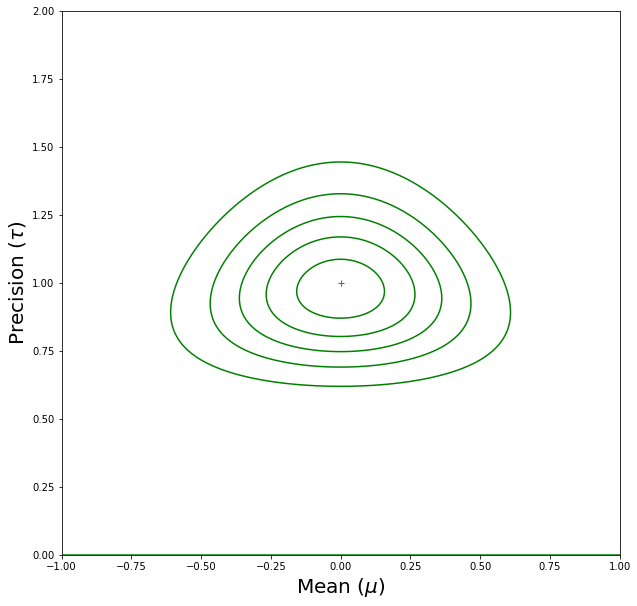

In [101]:
# Generate Interpolation Grid:
mus = np.linspace(MEAN-1, MEAN+1, 400)
taus = np.linspace(PRECISION-1, PRECISION+1, 400)
 
# Now we can compute the probabilities:
Z_Prior = np.empty([len(mus), len(taus)])
#  We can create pTau as this is independent of anything:
pTau = gamma(a=A_0, loc=0, scale=1/B_0)
#  Since Mu depends on Tau, we will have to compute this in a loop
for i_t, tau in enumerate(taus):
    pMu = norm(loc=MU_0, scale=1/np.sqrt(LAMB_0 * tau))
    Z_Prior[:, i_t] = pMu.pdf(mus) * pTau.pdf(tau)
 
# Now Plot
plt.figure(figsize=[10,10])
plt.plot(MEAN, PRECISION, '+', label='Actual')
plt.contour(*np.meshgrid(mus, taus), Z_Prior.T, levels=5, colors=['green'])
# plt.xlim([MEAN-0.15, MEAN + 0.25])
# plt.ylim([PRECISION-0.25, PRECISION+0.25])
plt.xlabel('Mean ($\mu$)', fontsize=20)
plt.ylabel('Precision ($\\tau$)', fontsize=20)


In [102]:
# Let us generate the Data and visualise it.
np.random.seed(0)
X = np.random.normal(loc=MEAN, scale=np.sqrt(1/PRECISION), size=N)

/var/folders/rs/c0n5lhyx7ml6xk3ndk1wy_1m0000gn/T/ipykernel_45633/1998185213.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  pMu = norm(loc=mu_p, scale=1/np.sqrt(lambda_p * tau))


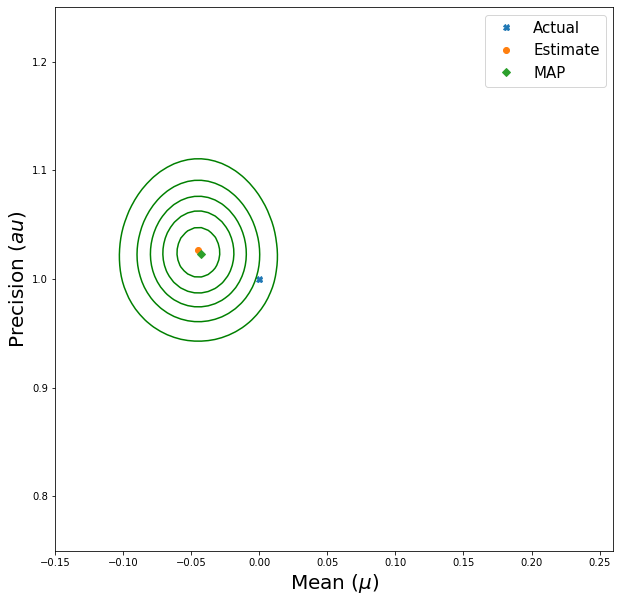

In [112]:
## EXACT with norm-gamma
# Parameters for the posterior distribution
mu_p = (N*X.mean() + MU_0*LAMB_0) / (N+LAMB_0)
lambda_p = N+LAMB_0
alpha_p = N/2 + A_0
beta_p = B_0 + 0.5*(N*np.square(X).mean() + LAMB_0*MU_0**2 - (N+LAMB_0)*mu_p**2)

# Now compute the probabilities from the densities
Z_Exact = np.empty_like(Z_Prior)
#  First create pTau since it is independent of other parameters. 
pTau = gamma(a=alpha_p, loc=0, scale=1/beta_p)
#  Create  pMu for every Tau since they are dependent
for i_t, tau in enumerate(taus):
    pMu = norm(loc=mu_p, scale=1/np.sqrt(lambda_p * tau))
    Z_Exact[:, i_t] = pMu.pdf(mus) * pTau.pdf(tau)
# Find the maximum
Z_mu_e, Z_tau_e = np.unravel_index(np.argmax(Z_Exact), Z_Exact.shape)
Z_mu_e, Z_tau_e = mus[Z_mu_e], taus[Z_tau_e]
 
# Now Plot
plt.figure(figsize=[10,10])
plt.plot(MEAN, PRECISION, 'X', label='Actual')
plt.plot(X.mean(), 1/X.var(), 'o', label='Estimate')
plt.plot(Z_mu_e, Z_tau_e, 'D', label='MAP')
plt.contour(*np.meshgrid(mus, taus), Z_Exact.T, levels=5, colors=['green'])
plt.xlim([-0.15, 0.26])
plt.ylim([0.75, 1.25])
plt.xlabel('Mean ($\mu$)', fontsize=20)
plt.ylabel('Precision ($\tau$)', fontsize=20)
_ = plt.legend(fontsize=15)



In [108]:
print(b_bar)
print(b_N)

507.61498967443373
71.31333562134711


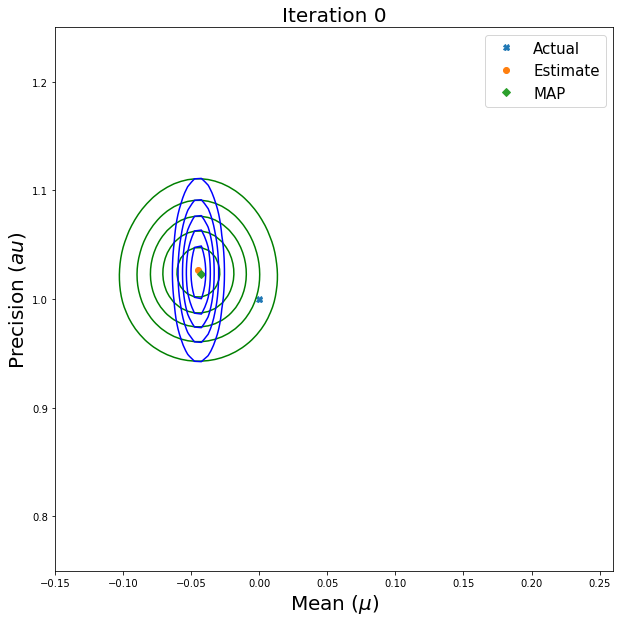

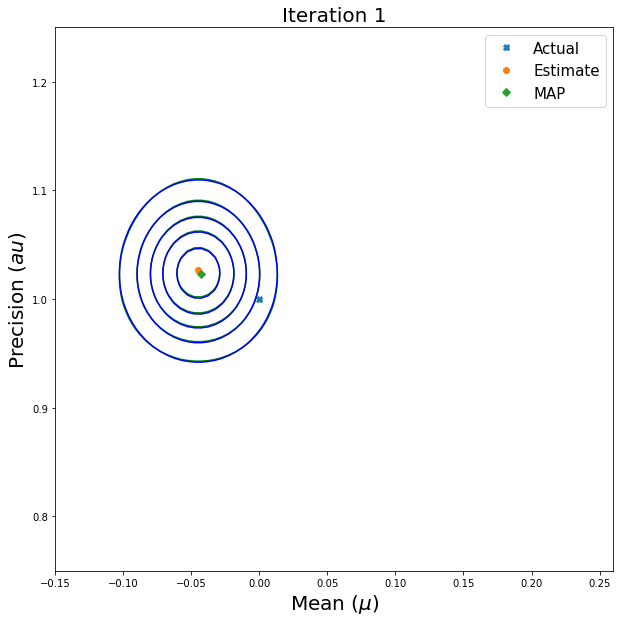

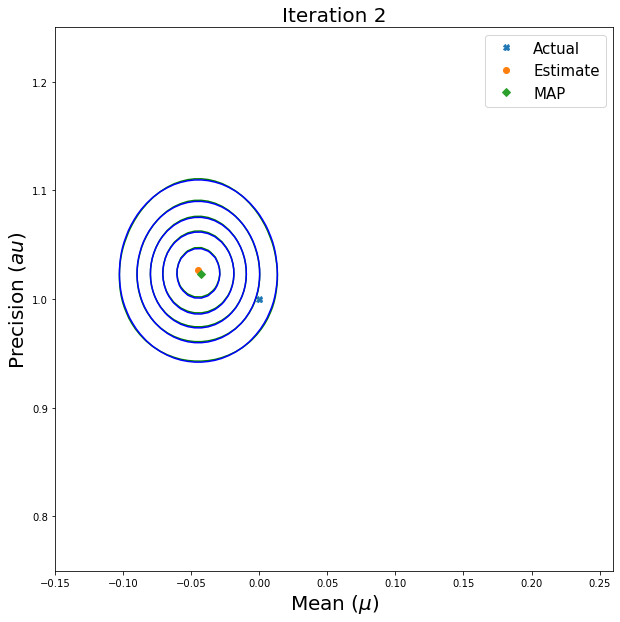

In [113]:
# We need to set up an initial value for tau: let us try 2 just for the sake of it.
E_tau = 10
E_tau_prev = np.NaN  # Keep track of tau until it does not change much:
iterations = 0

# FInding the posterior in an iterative manner
while np.isnan(E_tau_prev) or (np.abs(E_tau - E_tau_prev) > TOLERANCE):
    # Calculate
    mu_bar = (LAMB_0 * MU_0 + N * X.mean())/(LAMB_0 + N)
    tau_bar = (LAMB_0 + N) * E_tau
    # Step A.2
    E_mu = mu_bar
    E_mu2 = tau_bar ** -1  + E_mu ** 2
    
    # Step B.1
    a_bar = A_0 + (N+1)/2
    b_bar = B_0 +  0.5*(N*np.square(X).mean() + LAMB_0*MU_0**2 ) + 0.5*(N+LAMB_0)*( E_mu2 - 2*mu_bar*E_mu )
    # Step B.2
    E_tau_prev = E_tau
    E_tau = a_bar/b_bar
    
    # Now Compute
    #  We will use the same intepolation grid as before: also, since now neither mu_bar nor tau_bar depend on tau directly, we
    #  can compute all at one go:
    pTau = gamma(a=a_bar, loc=0, scale=1/b_bar)
    pMu = norm(loc=mu_bar, scale=1/np.sqrt(tau_bar))
    Z_IVI = np.outer(pMu.pdf(mus), pTau.pdf(taus))

    # Find the maximum
    Z_mu_I, Z_tau_I = np.unravel_index(np.argmax(Z_IVI), Z_IVI.shape)
    Z_mu_I, Z_tau_I = mus[Z_mu_I], taus[Z_tau_I]
    
    # Now Plot
    plt.figure(figsize=[10,10])
    plt.plot(MEAN, PRECISION, 'X', label='Actual')
    plt.plot(X.mean(), 1/X.var(), 'o', label='Estimate')
    plt.plot(Z_mu_I, Z_tau_I, 'D', label='MAP')
    plt.contour(*np.meshgrid(mus, taus), Z_Exact.T, levels=5, colors=['green'])
    plt.contour(*np.meshgrid(mus, taus), Z_IVI.T, levels=5, colors=['blue'])
    plt.xlim([-0.15, 0.26])
    plt.ylim([0.75, 1.25])
    plt.title('Iteration {}'.format(iterations), fontsize=20)
    plt.xlabel('Mean ($\mu$)', fontsize=20)
    plt.ylabel('Precision ($\tau$)', fontsize=20)
    _ = plt.legend(fontsize=15)
    
    iterations += 1

In [111]:

print(b_bar)
print(b_N)
print(E_tau)
print(E_mu)

507.61498967443373
71.31333562134711
1.0253834315133803
-0.04480862127742117
